In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints, transforms
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from patsy import dmatrix
plt.style.use('ggplot')

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter 5

## Polynomial Regression

## Expanding the Feature Space

## Introducing Splines

In [6]:
x = np.linspace(0, 1, 100)

beta = dist.TransformedDistribution(
        dist.Normal(torch.tensor(0.), torch.tensor(1.)), 
        transforms=transforms.AbsTransform()
        )

for i in range(4):
    beta = dist.TransformedDistribution(
        dist.Normal(torch.tensor(0.), torch.tensor(1.)), 
        transforms=transforms.AbsTransform()
        )


## Fitting Splines

In [2]:
day = pd.read_csv('/Users/wastechs/Documents/data/Bike-Sharing-Dataset/day.csv')
hour = pd.read_csv('/Users/wastechs/Documents/data/Bike-Sharing-Dataset/hour.csv')

In [3]:
hour['cnt_std'] = hour['cnt'] / hour['cnt'].max()

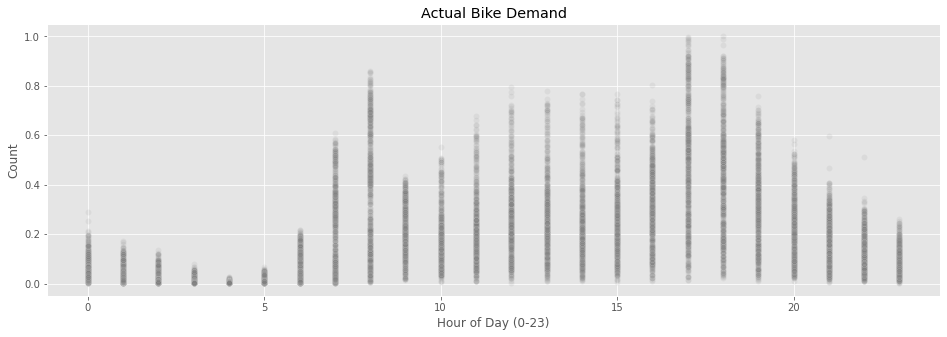

In [51]:
plt.figure(figsize=(16, 5))
sns.scatterplot(x=hour['hr'], y=hour['cnt_std'], alpha=0.1, color='grey')
plt.ylabel('Count')
plt.xlabel('Hour of Day (0-23)')
plt.title('Actual Bike Demand')
plt.show()

In [5]:
num_knots = 6
knot_list = torch.linspace(0, 23, num_knots + 2)[1:-1]

In [93]:
B = dmatrix(
    "bs(cnt_std, knots=knots, degree=3, include_intercept=True) - 1",
    {'cnt_std': hour.hr.values, 'knots': knot_list[1:-1]}
)

B = torch.tensor(np.asarray(B)).float()
cnt_bikes = torch.tensor(hour['cnt_std'].values).float()
hour_bikes = torch.tensor(hour['hr'].values).reshape(-1, 1).float()

In [80]:
def splines(design_matrix, count_bikes=None):

    N, P = design_matrix.shape

    tau = pyro.sample('tau', dist.HalfCauchy(1.))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    beta = pyro.sample('beta', dist.Normal(0., tau).expand([P]))
    mu = pyro.deterministic('mu', torch.matmul(beta, design_matrix.T))

    with pyro.plate('output', N):
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=count_bikes)


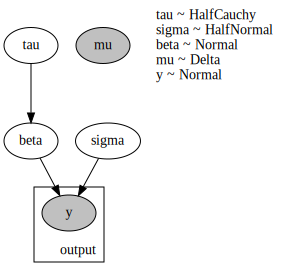

In [81]:
pyro.render_model(
    splines, (B, cnt_bikes), render_distributions=True
)

In [45]:
kernel = NUTS(splines)
mcmc_splines = MCMC(kernel, 500, 300)
mcmc_splines.run(B, cnt_bikes)

Sample: 100%|██████████| 800/800 [00:26, 30.35it/s, step size=2.60e-01, acc. prob=0.900]


In [ ]:
spline_samples = mcmc_splines.get_samples(1000)
splines_predictive = Predictive(splines, spline_samples)(B, None)
az_splines_pred = az.from_pyro(posterior=mcmc_splines, posterior_predictive=splines_predictive)

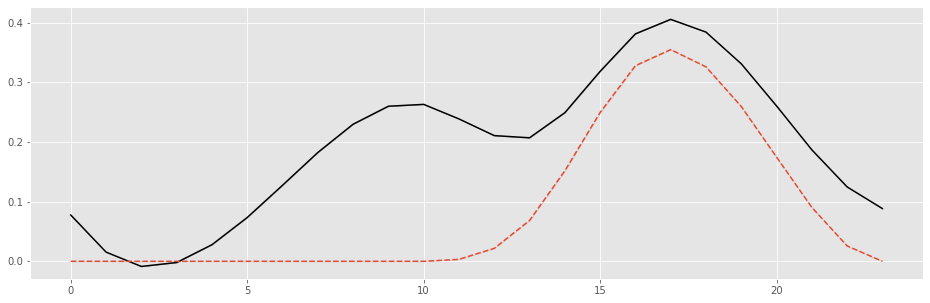

In [148]:
plt.figure(figsize=(16, 5))
sns.lineplot(
    x=hour_bikes.flatten(), y=splines_predictive['mu'].mean(axis=0).T.flatten(),
    color='black'
    )
sns.lineplot(
    x=hour_bikes.flatten(), y=(B * spline_samples['beta'].mean(axis=0))[:, 5],
    linestyle='--'
    )



plt.show()

In [159]:
cnt_mu = splines_predictive['y'].mean(axis=0).T.flatten()
cnt_std = splines_predictive['y'].std(axis=0).T.flatten()

df = pd.DataFrame({
    'hr': hour['hr'].values,
    'cnt_scaled': hour['cnt_std'].values,
    'cnt_mu': cnt_mu,
    'cnt_std': cnt_std,
    'cnt_high': cnt_mu + cnt_std,
    'cnt_low': cnt_mu - cnt_std
})

df = df.sort_values(by=['hr'])

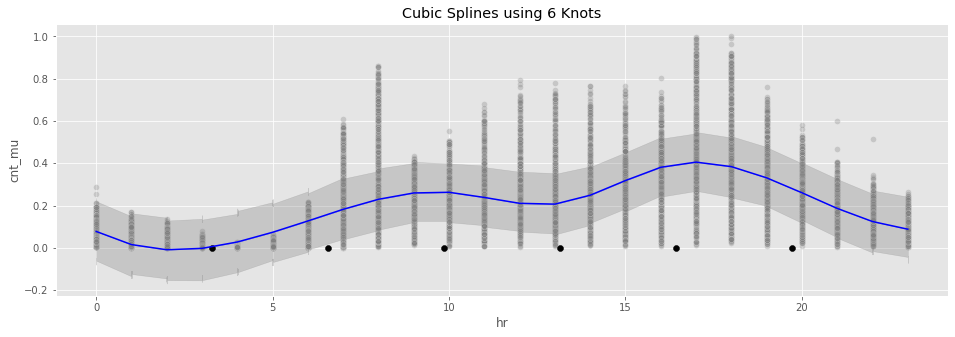

In [175]:
plt.figure(figsize=(16, 5))
sns.lineplot(
    x=df['hr'], y=df['cnt_mu'], color='blue')
sns.scatterplot(
    x=hour['hr'], y=hour['cnt_std'], color='grey', alpha=0.3
    )
plt.fill_between(
    x=df['hr'], y1=df['cnt_high'], y2=df['cnt_low'], color='grey',
    alpha=0.3
    )
plt.scatter(knot_list, np.zeros_like(knot_list), color='black')
plt.title('Cubic Splines using 6 Knots')
plt.show()